In [ ]:
!pip install spacy



In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

In [3]:
data1 = pd.read_excel("filtered_data.xlsx", usecols=['tweets', 'class'])
data1.head()

,tweets,class
0,'Disrespected the wife of Prophet' - pseudo li...,irony
1,Looking forward to next week and stepping away...,irony
2,Get to work to realize oatmeal packet I grabbe...,irony
3,@WeirdToBe waise what blocking means to nida i...,irony
4,@JillHS23 He has stated he wants to 'destroy t...,irony


Handled the Duplication and Inconsistencies

Insights from EDA- Duplicate values:

Out of 13,381 tweets, all duplicates marked as sarcasm have a copy marked as figurative.
Similarly, all duplicates marked as irony are also marked as FIGURATIVE.
There are an additional 13,418 rows when sarcasm and irony row counts are added.
Thus, there are 37 additional duplicates in sarcasm or irony or regular apart from figurative.
18 rows contain only irony. Only 1 seems to be a relevant ironic statement.
Example: "Some girls want to be treated like queens but they do not know how to be one. #irony"
This has 9 duplicate values out of the 18.
The others are marked as #ironic, #irony, etc.
There are 5 rows marked as #sarcasm with class "sarcasm" and 4 duplicate values.
Actions to Take:

Remove the 5 rows marked as #sarcasm with class "sarcasm".
For the 50 regular tweets, remove duplicates as the same tweets have been reposted.
For the remaining 13,382 tweets tagged as figurative, sarcasm, and irony, combine them under the figurative class and then remove duplicates.
In other words, keep the figurative class tweets.
Final Insights:

After processing, there will be a total of 13,469 actionable rows.
For the 50 regular tweets, we will remove duplicates.
For the 13,382 tweets tagged as figurative, sarcasm, and irony combined, we will keep the figurative class and remove duplicates.
There are 37 remaining rows with irony or sarcasm where duplicates can be removed.







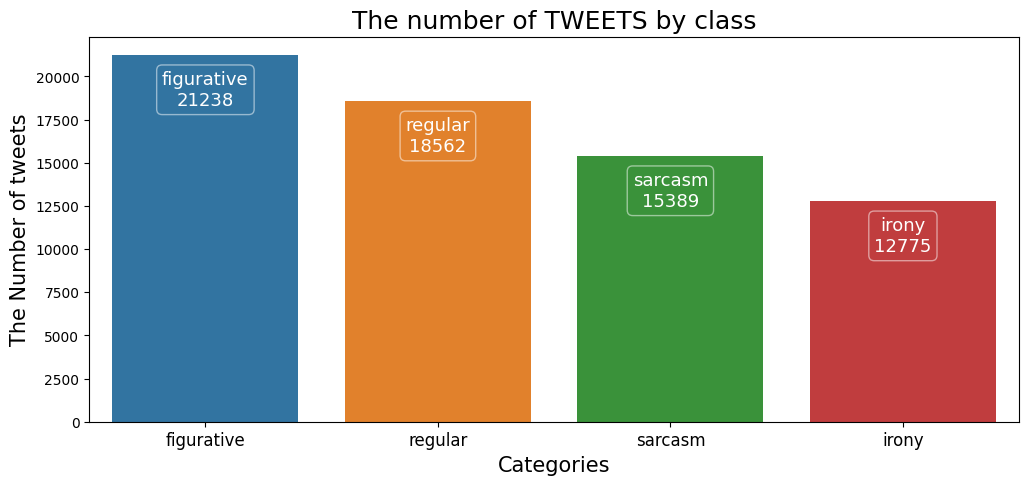

In [4]:
# Bar plot for each of the new category
category_count = data1['class'].value_counts()

categories = category_count.index
data1['class'].value_counts()
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of tweets', size= 15)

plt.xticks(size = 12)

plt.title("The number of TWEETS by class" , size = 18)

plt.show()



1.   The business decision is to retain the figurative records and remove the irony and sarcasm classes.
2.   After removing duplicates, the dataset has highly unbalanced classes.




In [5]:
import re
import numpy as np
def remove_pattern(text, exp):
    if isinstance(text, str):
        r = re.findall(exp, text)
        for i in r:
            text = re.sub(re.escape(i), "", text)
        return text
    else:
        return ""

In [9]:
#removal of @
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['tweets'],"@[\w]*")
#removal of Https
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['clean_tweets'],"https[\S]*")
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['clean_tweets'],"http[\S]*")
#removal of #
data1['clean_tweets']=np.vectorize(remove_pattern)(data1['clean_tweets'],"#")
# Define words to remove for figurative class (class 1)
words_to_remove = ['sarcasm', 'irony','ironic','sarcastic']

# Apply word removal only to rows with class 1
data1['clean_tweets'][data1['class'] == 'figurative'] = data1[data1['class'] == 'figurative']['clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in words_to_remove]))

data1.to_excel('cleantweets.xlsx', index=False)

In [10]:
import string
#removing the punctation
pun=string.punctuation
pun

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
for i in range(0,len(data1['clean_tweets'])):
  text=data1['clean_tweets'][i]
  no_pun=[char for char in text if char not in pun]
  no_pun=''.join(no_pun)
  data1['clean_tweets'][i]=no_pun

data1.head()


,tweets,class,clean_tweets
0,'Disrespected the wife of Prophet' - pseudo li...,irony,Disrespected the wife of Prophet pseudo libta...
1,Looking forward to next week and stepping away...,irony,Looking forward to next week and stepping away...
2,Get to work to realize oatmeal packet I grabbe...,irony,Get to work to realize oatmeal packet I grabbe...
3,@WeirdToBe waise what blocking means to nida i...,irony,waise what blocking means to nida is awesome ...
4,@JillHS23 He has stated he wants to 'destroy t...,irony,He has stated he wants to destroy the IS Cali...


In [12]:
# remove both the leading and the trailing characters
data1['clean_tweets']=[x.strip() for x in data1.clean_tweets]
#data1['clean_tweets']=[x for x in data1.clean_tweets if x]
data1.head()


,tweets,class,clean_tweets
0,'Disrespected the wife of Prophet' - pseudo li...,irony,Disrespected the wife of Prophet pseudo libta...
1,Looking forward to next week and stepping away...,irony,Looking forward to next week and stepping away...
2,Get to work to realize oatmeal packet I grabbe...,irony,Get to work to realize oatmeal packet I grabbe...
3,@WeirdToBe waise what blocking means to nida i...,irony,waise what blocking means to nida is awesome i...
4,@JillHS23 He has stated he wants to 'destroy t...,irony,He has stated he wants to destroy the IS Calip...


In [ ]:
import spacy
from tqdm import tqdm

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

# Assuming you have a DataFrame named data1 with 'clean_tweets' and 'word_token' columns

# Define the preprocess function using spaCy tokenizer
def preprocess_text(text):
    # Tokenize using spaCy
    tokens = [token.text for token in nlp(text)]
    return tokens

# Apply the preprocess function to the 'clean_tweets' column with tqdm
tqdm.pandas()  # Initialize tqdm for pandas apply
data1['word_token'] = data1['clean_tweets'].progress_apply(preprocess_text)

# Convert text to lowercase
data1['clean_tweets'] = data1['clean_tweets'].apply(lambda x: x.lower())

# Convert tokens to lowercase
data1['word_token'] = data1['word_token'].apply(lambda x: [word.lower() for word in x])

# Lemmatize using spaCy
data1['lemmatized'] = data1['word_token'].apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])



 83%|████████▎ | 56598/67964 [10:00<01:44, 108.63it/s]

In [14]:

# Display the updated DataFrame
data1.head()

,tweets,class,clean_tweets,word_token,lemmatized
0,'Disrespected the wife of Prophet' - pseudo li...,irony,disrespected the wife of prophet pseudo libta...,"[disrespected, the, wife, of, prophet, , pseu...","[disrespect, the, wife, of, prophet, , pseud..."
1,Looking forward to next week and stepping away...,irony,looking forward to next week and stepping away...,"[looking, forward, to, next, week, and, steppi...","[look, forward, to, next, week, and, step, awa..."
2,Get to work to realize oatmeal packet I grabbe...,irony,get to work to realize oatmeal packet i grabbe...,"[get, to, work, to, realize, oatmeal, packet, ...","[get, to, work, to, realize, oatmeal, packet, ..."
3,@WeirdToBe waise what blocking means to nida i...,irony,waise what blocking means to nida is awesome i...,"[waise, what, blocking, means, to, nida, is, a...","[waise, what, blocking, mean, to, nida, be, aw..."
4,@JillHS23 He has stated he wants to 'destroy t...,irony,he has stated he wants to destroy the is calip...,"[he, has, stated, he, wants, to, destroy, the,...","[he, have, state, he, want, to, destroy, the, ..."


In [ ]:
data1.shape

(67964, 4)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import pandas as pd

# Create a TfidfVectorizer instance with standard English stopwords
tfidf_sar = TfidfVectorizer(norm="l1", analyzer='word', ngram_range=(1, 2), max_features=500, stop_words='english')

# Fit and transform the text data with tqdm
X = tfidf_sar.fit_transform(tqdm(data1['clean_tweets'], desc="TF-IDF Transformation"))

# Sum the TF-IDF scores for each word across all documents
sum_words = X.sum(axis=0)

# Create a list of (word, TF-IDF sum) tuples, excluding "not"
words_freq = [(word, sum_words[0, tfidf_sar.vocabulary_[word]]) for word in tfidf_sar.vocabulary_ if word != "not"]

# Sort the words by their TF-IDF sums in descending order
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Create a DataFrame from the sorted list of word frequencies
wd_df = pd.DataFrame(words_freq, columns=['word', 'weight'])

# Save the DataFrame to a CSV file
wd_df.to_csv("tweets_ngram_tfidf.csv", index=False)

# Display the top 10 words with their TF-IDF scores
print(wd_df.head(10))


TF-IDF Transformation: 100%|██████████| 67964/67964 [00:02<00:00, 33612.76it/s]


       word       weight
0   sarcasm  3246.211573
1     irony  2656.280004
2      news  1058.526845
3    ironic   986.445463
4     peace   974.011025
5     drugs   960.123110
6      late   893.635945
7     humor   835.872884
8      just   816.330321
9  politics   802.184371


TfidfVectorizer (Term Frequency-Inverse Document Frequency):

It calculates a normalized value that takes into account both the frequency of a word in a document and its importance in the entire corpus.
It assigns higher weights to words that are more unique to a document, while penalizing words that are common across many documents.
It's particularly useful for tasks like information retrieval, text clustering, and recommendation systems, where you want to capture

lemmatization included because of irony and ironic

In [27]:


# # Load the spaCy English language model
# nlp = spacy.load("en_core_web_sm")

# # Define a function for text preprocessing and lemmatization
# def preprocess_and_lemmatize(text):
#     doc = nlp(text)
#     lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
#     return " ".join(lemmatized_tokens)

# # Apply preprocessing and lemmatization to the 'clean_tweets' column
# data1['clean_tweets'] = data1['clean_tweets'].progress_apply(preprocess_and_lemmatize)

# # Create a TfidfVectorizer instance with standard English stopwords
# tfidf_sar = TfidfVectorizer(norm="l1", analyzer='word', ngram_range=(1, 2), max_features=650, stop_words='english')

# # Fit and transform the text data with tqdm
# X = tfidf_sar.fit_transform(tqdm(data1['clean_tweets'], desc="TF-IDF Transformation"))

# # Sum the TF-IDF scores for each word across all documents
# sum_words = X.sum(axis=0)

# # Create a list of (word, TF-IDF sum) tuples
# words_freq = [(word, sum_words[0, tfidf_sar.vocabulary_[word]]) for word in tfidf_sar.vocabulary_ if word != "not"]

# # Sort the words by their TF-IDF sums in descending order
# words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# # Create a DataFrame from the sorted list of word frequencies
# wd_df = pd.DataFrame(words_freq, columns=['word', 'weight'])

# # Save the DataFrame to a CSV file
# wd_df.to_csv("tweets_ngram_tfidf.csv", index=False)

# # Display the top 10 words with their TF-IDF scores
# print(wd_df.head(10))
# # Access the vocabulary of the TfidfVectorizer
# vocabulary = tfidf_sar.vocabulary_

# # Sort the vocabulary dictionary by TF-IDF scores in descending order
# sorted_vocabulary = {word: vocabulary[word] for word in sorted(vocabulary, key=lambda word: -word_tfidf_scores.get(word, 0))}

# # Print the sorted vocabulary
# print("Vocabulary:", sorted_vocabulary)

# Access the vocabulary of the TfidfVectorizer


In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data1['class_encoded'] = label_encoder.fit_transform(data1['class'])


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, data1['class_encoded'], test_size=0.2, random_state=42, stratify=data1['class_encoded']
)



In [30]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

# # Lists to store results for visualization
# model_names = []
# cv_accuracies = []

# # Define a list of models to consider
# models = [
#     ('Naive Bayes', MultinomialNB(), {'alpha': [0.1, 0.5, 1.0]}),
#     ('Logistic Regression', LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
#     ('Support Vector Machine', SVC(), {'C': [0.1], 'kernel': ['linear', 'rbf']}),
#     ('Random Forest', RandomForestClassifier(), {'n_estimators': [50]}),
#     ('XGBoost', XGBClassifier(), {'n_estimators': [10,50]})
# ]

# best_model = None
# best_accuracy = 0

# # Loop through each model, perform grid search, and select the best model
# for model_name, model, param_grid in tqdm(models, desc="Model Selection Progress"):
#     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
# #     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', stratify=y_train)

#     grid_search.fit(X_train, y_train)

#     best_params = grid_search.best_params_
#     best_score = grid_search.best_score_

#     print(f"{model_name} - Best Parameters:", best_params)
#     print(f"{model_name} - Best Cross-Validation Accuracy:", best_score)

#     model_names.append(model_name)
#     cv_accuracies.append(best_score)

#     if best_score > best_accuracy:
#         best_accuracy = best_score
#         best_model = grid_search.best_estimator_

# print("Best Model:", best_model)

# # Visualize Cross-Validation Accuracies
# plt.figure(figsize=(10, 6))
# sns.barplot(x=cv_accuracies, y=model_names, palette='viridis')
# plt.xlabel('Cross-Validation Accuracy')
# plt.ylabel('Model')
# plt.title('Cross-Validation Accuracies of Different Models')
# plt.show()

# # Evaluate the best model on the test set
# best_model.fit(X_train, y_train)
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Best Model Test Accuracy:", accuracy)


In [31]:
# from sklearn.metrics import classification_report
# # Evaluate the best model on the test set
# best_model.fit(X_train, y_train)
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Best Model Test Accuracy:", accuracy)

# y_pred_prob = best_model.predict_proba(X_test)

# # After evaluating the best model and obtaining y_pred

# # Decode the encoded class labels back to actual class names
# y_test_actual = label_encoder.inverse_transform(y_test)
# y_pred_actual = label_encoder.inverse_transform(y_pred)



# # Generate classification report
# report = classification_report(y_test_actual, y_pred_actual)
# print("Classification Report:\n", report)

**INSIGHTS - Insights:**

The model performs well for classes with higher support ("irony," "regular," and "sarcasm"), achieving good recall and F1-scores. The "sarcasm" class, in particular, has high precision, recall, and F1-score, suggesting that the model is effective at identifying sarcasm instances.
The model struggles with the "figurative" class, as
indicated by the low precision, recall, and F1-score. It seems that distinguishing "figurative" from other classes is challenging for the model.
The weighted-average F1-score is lower than desired, which could be due to the imbalanced class distribution and the model's difficulty in predicting the "figurative" class.

**precision-recall curves and calculate the Area Under the Precision-Recall Curve (AUC-PR)**

In [32]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Compute ROC curve for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# # Calculate ROC curve and AUC-ROC for each class
# for i in range(len(label_encoder.classes_)):
#     fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves
# plt.figure(figsize=(10, 6))
# plt.plot(fpr[0], tpr[0], color='b', label='figurative (AUC = {:.2f})'.format(roc_auc[0]))
# plt.plot(fpr[1], tpr[1], color='g', label='irony (AUC = {:.2f})'.format(roc_auc[1]))
# plt.plot(fpr[2], tpr[2], color='r', label='regular (AUC = {:.2f})'.format(roc_auc[2]))
# plt.plot(fpr[3], tpr[3], color='m', label='sarcasm (AUC = {:.2f})'.format(roc_auc[3]))

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves')
# plt.legend()
# plt.show()

# # Calculate and print overall average AUC-ROC
# overall_average_roc_auc = sum(roc_auc.values()) / len(roc_auc)
# print("Overall Average AUC-ROC: {:.2f}".format(overall_average_roc_auc))


Figurative (AUC-ROC = 0.72): The AUC-ROC value for the "figurative" class is 0.72. This indicates the classifier's ability to distinguish between positive and negative instances for the "figurative" class. A higher AUC-ROC value suggests better separation between the two classes, but the value of 0.72 still indicates a reasonable level of discrimination.

Irony (AUC-ROC = 0.90): The AUC-ROC value for the "irony" class is 0.90. This suggests that the classifier is performing well in distinguishing between positive and negative instances for the "irony" class. A value close to 1 indicates a high ability to discriminate between the two classes.

Regular (AUC-ROC = 1): The AUC-ROC value for the "regular" class is 1. A value of 1 implies perfect separation between positive and negative instances for this class. This indicates that the classifier has achieved ideal performance in distinguishing between the two classes in the "regular" category.

Sarcasm (AUC-ROC = 0.92): The AUC-ROC value for the "sarcasm" class is 0.92. Similar to the "irony" class, this indicates that the classifier is performing well in distinguishing between positive and negative instances for the "sarcasm" class.

Overall Average AUC-ROC = 0.88: The overall average AUC-ROC value is 0.88, which is a measure of the model's overall performance across all classes. This value represents the average of the AUC-ROC values for each individual class. An overall AUC-ROC value of 0.88 suggests that the model is performing quite well in distinguishing between classes on average.

**Recommendations:**

WE can Consider exploring strategies to improve the model's performance on the "figurative" class. This could involve adjusting class weights, or fine-tuning the model.
Since "figurative" has a very low precision, it might be beneficial to review and understand the specific misclassifications to identify patterns and areas for improvement.[CAN CHECK AROUND DELETING THE DUPLICATES THAT ARE FIGURATIVE RATHER THAN SARCASM AND IRONY AS CONSIDERED IN THE INITIAL STAGE OF THIS EXERCISE]


In [61]:
# # code is without the optimisation visualizations

# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import GridSearchCV
# from tqdm import tqdm_notebook

# # Define the hyperparameters and their possible values for tuning
# param_grid = {
#     'n_estimators': [20, 50, 100],
#     'learning_rate': [0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'random_state': [42]
# }

# # Create the XGBoost classifier
# xgb_model = XGBClassifier()

# # Perform Grid Search with cross-validation and tqdm
# with tqdm_notebook(total=len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth']), desc="Grid Search Progress") as pbar:
#     grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
#     grid_search.fit(X_train, y_train)
#     pbar.update(1)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_model.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print("Best Model Test Accuracy:", accuracy)

# # Generate classification report
# report = classification_report(y_test, y_pred)
# print("Classification Report:\n", report)

# # Print the best hyperparameters found during the grid search
# print("Best Hyperparameters:", grid_search.best_params_)


In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the hyperparameters and their possible values for tuning
param_grid = {
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4, 5],
    'random_state': [42]
}

# Create the XGBoost classifier
xgb_model = XGBClassifier()

# Initialize lists to store results
learning_rate_results = []
max_depth_results = []
n_estimators_results = []

# Perform Grid Search with cross-validation and tqdm
total_combinations = len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth'])
with tqdm(total=total_combinations, desc="Grid Search Progress") as pbar:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            for max_depth in param_grid['max_depth']:
                xgb_model = XGBClassifier(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    random_state=42,
                    eval_metric=["merror", "mlogloss"]
                )
                # Define an evaluation set to monitor the optimization process

                eval_set = [(X_train, y_train), (X_test, y_test)]
                xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
                y_pred = xgb_model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                learning_rate_results.append((n_estimators, learning_rate, max_depth, accuracy))

                # Calculate and store the evaluation results
                evals_result = xgb_model.evals_result()
                train_merror = evals_result['validation_0']['merror']
                test_merror = evals_result['validation_1']['merror']
                train_mlogloss = evals_result['validation_0']['mlogloss']
                test_mlogloss = evals_result['validation_1']['mlogloss']
                max_depth_results.append((n_estimators, learning_rate, max_depth, train_merror, test_merror, train_mlogloss, test_mlogloss))

                pbar.update(1)

# Perform Grid Search with cross-validation and tqdm
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Extract the results from GridSearchCV
cv_results = grid_search.cv_results_
n_estimators_values = cv_results['param_n_estimators']
learning_rate_values = cv_results['param_learning_rate']
max_depth_values = cv_results['param_max_depth']
accuracy_values = cv_results['mean_test_score']

# Extract and visualize the results
n_estimators_values = [result[0] for result in learning_rate_results]
learning_rate_values = [result[1] for result in learning_rate_results]
max_depth_values = [result[2] for result in learning_rate_results]
accuracy_values = [result[3] for result in learning_rate_results]

# Print the best hyperparameters found during the grid search
print("Best Hyperparameters:", grid_search.best_params_)


Grid Search Progress: 100%|██████████| 18/18 [03:49<00:00, 12.75s/it]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'random_state': 42}


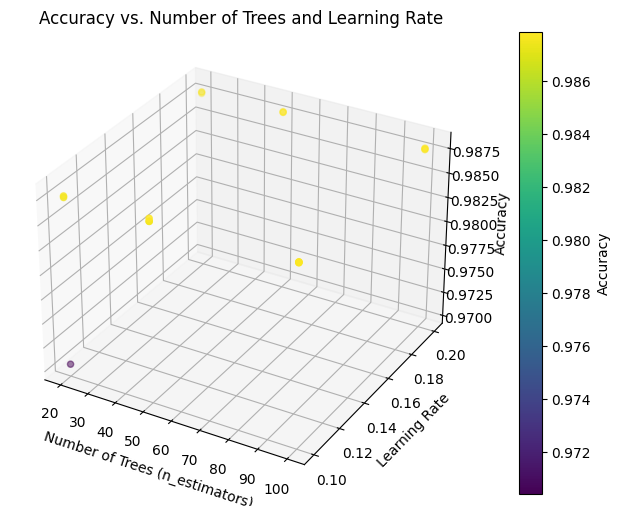

In [67]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot for accuracy vs. n_estimators and learning_rate
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(n_estimators_values, learning_rate_values, accuracy_values, c=accuracy_values, cmap='viridis', marker='o')

# Set labels and title
ax.set_xlabel('Number of Trees (n_estimators)')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy vs. Number of Trees and Learning Rate')

# Add a color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Accuracy', rotation=90)

plt.show()



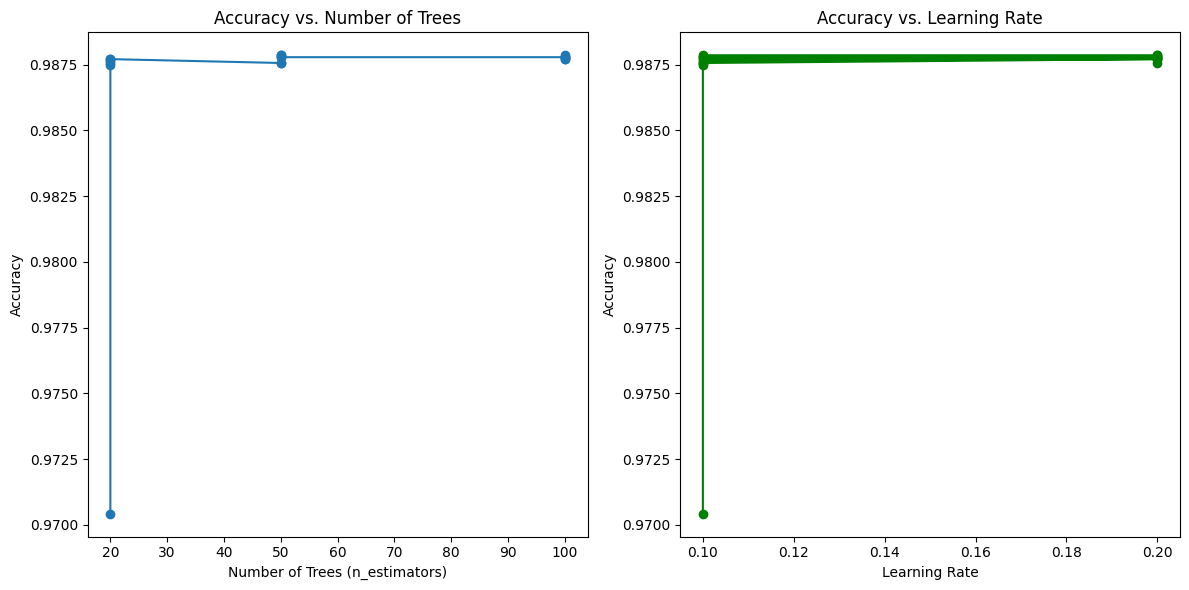

In [69]:
# Create line plots for accuracy vs. n_estimators and learning_rate

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy vs. Number of Trees (n_estimators)
plt.subplot(1, 2, 1)
plt.plot(n_estimators_values, accuracy_values, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Trees')

# Subplot 2: Accuracy vs. Learning Rate
plt.subplot(1, 2, 2)
plt.plot(learning_rate_values, accuracy_values, marker='o', color='green')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Learning Rate')

plt.tight_layout()
plt.show()


In [ ]:
# plt.subplot(1, 3, 2)
# plt.scatter(max_depth_values, train_merror, c=learning_rate_values, cmap='viridis', marker='o', label='Train')
# plt.scatter(max_depth_values, test_merror, c=learning_rate_values, cmap='viridis', marker='x', label='Test')
# plt.xlabel('Max Depth (max_depth)')
# plt.ylabel('Classification Error (merror)')
# plt.title('Classification Error vs. Max Depth and Learning Rate')
# plt.colorbar(label='Learning Rate')
# plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(max_depth_values, train_mlogloss, c=learning_rate_values, cmap='viridis', marker='o', label='Train')
plt.scatter(max_depth_values, test_mlogloss, c=learning_rate_values, cmap='viridis', marker='x', label='Test')
plt.xlabel('Max Depth (max_depth)')
plt.ylabel('Log Loss (mlogloss)')
plt.title('Log Loss vs. Max Depth and Learning Rate')
plt.colorbar(label='Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# code without optimization analysis

# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Create and train the XGBoost model with hyperparameters
# best_model = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=5, random_state=42)
# # Define an evaluation set to monitor the optimization process
# eval_set = [(X_train, y_train), (X_test, y_test)]

# # Train the model and monitor cost function optimization
# best_model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

# # # best_model.fit(X_train, y_train)
# # Make predictions on the training set
# y_train_pred = best_model.predict(X_train)

# # Calculate training accuracy
# train_accuracy = accuracy_score(y_train, y_train_pred)
# print("Best Model Training Accuracy:", train_accuracy)

# # Make predictions on the test set
# y_test_pred = best_model.predict(X_test)

# # Calculate test accuracy
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print("Best Model Test Accuracy:", test_accuracy)

# # Decode the encoded class labels back to actual class names
# y_test_actual = label_encoder.inverse_transform(y_test)
# y_pred_actual = label_encoder.inverse_transform(y_test_pred)

# # Generate classification report for the test set
# report = classification_report(y_test_actual, y_pred_actual)
# print("Classification Report:\n", report)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the XGBoost model with hyperparameters
best_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.2,
    max_depth=5,
    random_state=42,
    eval_metric=["merror", "mlogloss"]  # Specify eval_metrics here If you want to calculate the log loss for multi-class classification, you can use the mlogloss metric
)

# Define an evaluation set to monitor the optimization process
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model and monitor cost function optimization
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Best Model Training Accuracy:", train_accuracy)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Best Model Test Accuracy:", test_accuracy)

# Decode the encoded class labels back to actual class names
y_test_actual = label_encoder.inverse_transform(y_test)
y_pred_actual = label_encoder.inverse_transform(y_test_pred)

# Generate classification report for the test set
report = classification_report(y_test_actual, y_pred_actual)
print("Classification Report:\n", report)



In [57]:
# Retrieve the evaluation results, including the cost function values
evals_result = best_model.evals_result()

# Access multi-class classification error ('merror') and log loss ('mlogloss')
train_merror = evals_result['validation_0']['merror']
test_merror = evals_result['validation_1']['merror']
train_mlogloss = evals_result['validation_0']['mlogloss']
test_mlogloss = evals_result['validation_1']['mlogloss']


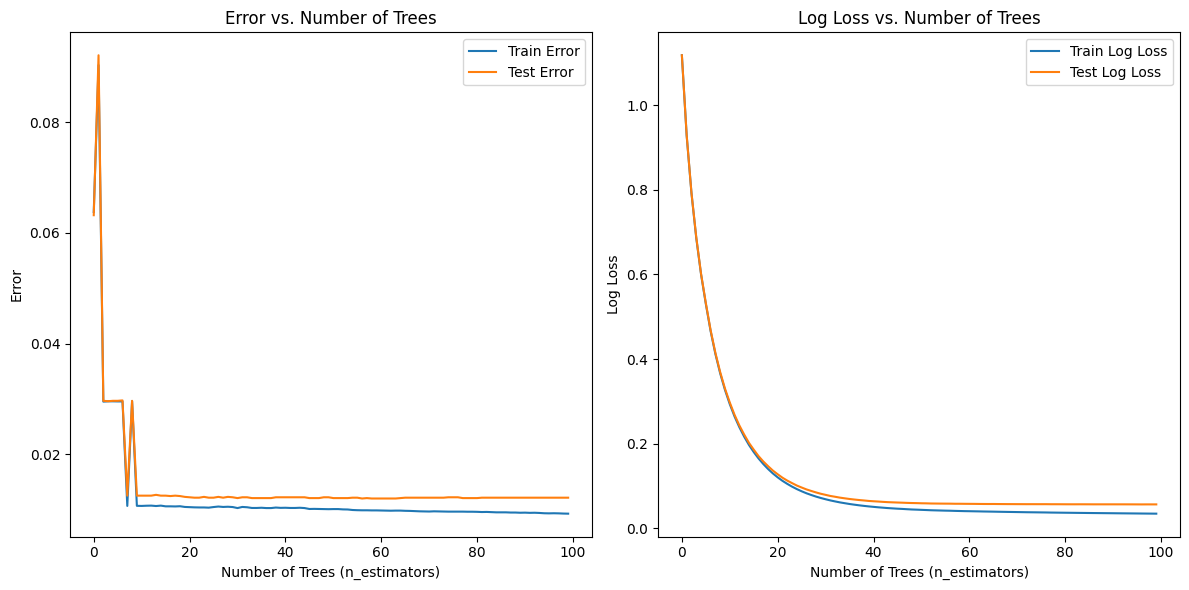

In [58]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_merror, label='Train Error')  # Updated to train_merror
plt.plot(test_merror, label='Test Error')    # Updated to test_merror
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Error')
plt.title('Error vs. Number of Trees')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mlogloss, label='Train Log Loss')  # Updated to train_mlogloss
plt.plot(test_mlogloss, label='Test Log Loss')    # Updated to test_mlogloss
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. Number of Trees')
plt.legend()

plt.tight_layout()
plt.show()


In [75]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the XGBoost model with hyperparameters
best_model = XGBClassifier(
    n_estimators=20, # 20,
    learning_rate=0.2,  # 0.2,
    max_depth=5,            #5,
    random_state=42,
    eval_metric=["merror", "mlogloss"]  # Specify eval_metrics here If you want to calculate the log loss for multi-class classification, you can use the mlogloss metric
)

# Define an evaluation set to monitor the optimization process
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model and monitor cost function optimization
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Best Model Training Accuracy:", train_accuracy)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Best Model Test Accuracy:", test_accuracy)

# Decode the encoded class labels back to actual class names
y_test_actual = label_encoder.inverse_transform(y_test)
y_pred_actual = label_encoder.inverse_transform(y_test_pred)

# Generate classification report for the test set
report = classification_report(y_test_actual, y_pred_actual)
print("Classification Report:\n", report)

Best Model Training Accuracy: 0.9895348623347004
Best Model Test Accuracy: 0.9877142646950636
Classification Report:
               precision    recall  f1-score   support

  figurative       1.00      0.96      0.98      4248
       irony       0.99      1.00      1.00      2555
     regular       0.97      1.00      0.98      3712
     sarcasm       0.99      1.00      1.00      3078

    accuracy                           0.99     13593
   macro avg       0.99      0.99      0.99     13593
weighted avg       0.99      0.99      0.99     13593



 **GRIDSEARCH - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'random_state': 42}**

# Create and train the XGBoost model with hyperparameters
best_model = XGBClassifier(
    n_estimators=50, # 20,
    learning_rate=0.1,  # 0.2,
    max_depth=5,            #5,
    random_state=42,
    eval_metric=["merror", "mlogloss"]  # Specify eval_metrics here If you want to calculate the log loss for multi-class classification, you can use the mlogloss metric
)
Best Model Training Accuracy: 0.9895716466498685
Best Model Test Accuracy: 0.9878613992496138





best_model1 = XGBClassifier(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=5,            
    random_state=42,
    eval_metric=["merror", "mlogloss"]  
)
Best Model1 Training Accuracy: 0.9893693329164445
Best Model1 Test Accuracy: 0.9876406974177886
================================================================================



best_model2 = XGBClassifier(
    n_estimators=20,
    learning_rate=0.1,  
    max_depth=3,           
    random_state=42,
    eval_metric=["merror", "mlogloss"]  # Specify eval_metrics here If you want to calculate the log loss for multi-class classification, you can use the mlogloss metric
)

Best Model2 Training Accuracy: 0.970278273344246
Best Model2 Test Accuracy: 0.9704259545354227

best_model3 = XGBClassifier(
    n_estimators=20,
    learning_rate=0.2,
    max_depth=5,          
    random_state=42,
    eval_metric=["merror", "mlogloss"]  # Specify eval_metrics here If you want to calculate the log loss for multi-class classification, you can use the mlogloss metric
)

Best Model3 Training Accuracy: 0.9895348623347004
Best Model3 Test Accuracy: 0.9877142646950636

FINAL COMMENTS :-Based on the provided accuracy scores, best_model and best_model3 have the highest test accuracy (0.9879 and 0.9877, respectively). Therefore, you might consider these two as the best models in terms of accuracy on the test set.

However, it's essential to consider other factors like model complexity and training time. Models with higher n_estimators and max_depth tend to be more complex and may require more training time and computational resources. If you prefer a simpler model or want faster training, you might choose best_model1 or best_model2.

CONCLUDING THOUGHTS - the choice of the best model depends on specific needs OF THE CLIENT. If accuracy is  primary concern and CLIENT is willing to invest more time and resources in training, best_model might be the best choice. If client wants a simpler and faster model with slightly lower accuracy, best_model1 or best_model2 could be preferred.